## NDWI: Normalized Difference Water Index for Alberta

This product is based on Modis data – 8day composites and we produce it on daily basis.
The Normalized Difference Water Index (NDWI) (Gao, 1996) is a satellite-derived index from the
Near-Infrared (NIR) and Short Wave Infrared (SWIR) channels. The SWIR reflectance reflects changes
in both the vegetation water content and the spongy mesophyll structure in vegetation canopies,
while the NIR reflectance is affected by leaf internal structure and leaf dry matter content but not by water content. The combination of the NIR with the SWIR removes variations induced by leaf
internal structure and leaf dry matter content, improving the accuracy in retrieving the vegetation
water content (Ceccato et al. 2001). The amount of water available in the internal leaf structure
largely controls the spectral reflectance in the SWIR interval of the electromagnetic spectrum. SWIR
reflectance is therefore negatively related to leaf water content (Tucker 1980
 
NDWI is defined as (p(0.86) - p(1.24))/ (p(0.86 ) + p(1.24)), where p represents the radiance in reflectance units. 
The daily NDWI product is dimensionless and varies between -1 to +1, depending on the leaf water content but also on the vegetation type and cover 
High values of NDWI green to blue colors correspond to high vegetation water content and to high vegetation fraction cover. 
Low NDWI  values (in red) correspond to low vegetation water content and low vegetation fraction cover. 
In period of water stress, NDWI will decrease.

Anomaly product 
 The NDWI anomaly product is given in standard deviation units. It is commonly ranging from -4 to +4 and from red to green, red showing negative anomalies (“anomaly_ndwi_4_years_20220407.png”).
The NDWI anomaly image is calculated by comparing this daily NDWI image to the historical series. The interpretation must take into account the fact that this indicator is showing a variation in the vegetation conditions.

In [ ]:
#import all libraries

In [ ]:

#from osgeo import gdal
import gdal
from osgeo import ogr
import  sys, shutil
from osgeo import osr
import subprocess, re
import os, glob, gdal
import datetime, osr, time
import numpy as np
import warnings
gdal.UseExceptions()


# print help(osgeo.ogr)
# use OGR specific exceptions
ogr.UseExceptions()
#from NBR_dnbr import procesRaster  #calculate NBR
#from rasterInfo import GDALTest
#from use_gdalFun import useGDAL   #funcions and executables from GDAL
#from MOD_prod_proc import proces_Evis
import matplotlib.pyplot as plt
from matplotlib import colors
from time import process_time
class proces_raster(object):

    def array2raster(self, out_raster_name, raster_in, array1):
        # raster = gdal.Open(raster_in)
        geotransform = raster_in.GetGeoTransform()
        proj = raster_in.GetProjectionRef()
        origin_x = geotransform[0]
        origin_y = geotransform[3]
        pixel_width = geotransform[1]
        pixel_height = geotransform[5]

        cols = raster_in.RasterXSize
        rows = raster_in.RasterYSize
        driver = gdal.GetDriverByName('GTiff')
        outRaster = driver.Create(out_raster_name, cols, rows, 1, gdal.GDT_Float32)
        outRaster.SetGeoTransform((origin_x, pixel_width, 0, origin_y, 0, pixel_height))
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(array1)  # 4 bnad cumulative

        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromEPSG(4326)
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()

    def save_vrt2tif(self, output_vrt, tifname):
        gdal_translate = r'C:/Program Files/GDAL/gdal_translate.exe'
        # save virt as tif

        cmd = '-of GTiff'
        tran_cmd = ' '.join([gdal_translate, cmd, output_vrt, tifname])
        print("transcom:", tran_cmd)
        subprocess.Popen(tran_cmd)
        # return tifname
    def vrt_mosac(self,output_vrt, dir ):
        ''' create vrt band to update main file'''
        buildvrt = r'C:/Program Files/GDAL/gdalbuildvrt.exe'

        cmd ="-separate " + output_vrt +' '+ dir + '/*.tif'
        #cmd = output_vrt + ' ' + dir
        fullCmd = ' '.join([buildvrt, cmd])
        print("fullcmd:", fullCmd)
        subprocess.Popen(fullCmd)
        print("output file is done")
        return


    def gdalmerge(self,output_vrt, direct_list):
        ''' create vrt band to update main file'''
        gdalmerge = r'C:/Program Files/GDAL/gdal_merge.py'
        cmd = "-separate -o " + output_vrt + ' -of GTiff ' + direct_list

        fullCmd = ' '.join([gdalmerge, cmd])
        print("gdalmerge:", fullCmd)
        subprocess.Popen(fullCmd)

        print("output file is done")
        print("\n")

    def mkdir(self,dirname, remove=True, chdir=False):
        import shutil
        """create a directory dirnme.  if it iexists     , it is removed by shutil.rmtree
        """
        if os.path.isdir(dirname):
            if remove:
                shutil.rmtree(dirname)
            else:
                return False  # did not make new directory
        os.mkdir(dirname)

        return

    def append_date(self,adatum, date_file):
        ''' when we do updates with a new file
        it opens a file with dates *.dates and append
        a new date to .dates file'''
        with open(date_file, 'a') as f:
            f.write(adatum)
            f.write('\n')
    def save_raster(self,output_name, raster_data, dataset, driver="GTiff"):
        """
        A function to save a 1-band raster using GDAL to the file indicated
        by ``output_name``.
        Parameters:
            output_name: str ........        The output filename, with full path and extension if required
        raster_data: array ........        The array that we want to save
        dataset: str.............        Filename of a GDAL-friendly dataset that we want to use to
            read geotransform & projection information
        driver: str .......        A GDAL driver string, like GTiff or HFA.
        """

        # Open the reference dataset
        g = gdal.Open(dataset)
        # Get the Geotransform vector
        geo_transform = g.GetGeoTransform()
        x_size = g.RasterXSize  # Raster xsize
        y_size = g.RasterYSize  # Raster ysize
        srs = g.GetProjectionRef()  # Projection
        # Need a driver object. By default, we use GeoTIFF
        driver = gdal.GetDriverByName(driver)
        dataset_out = driver.Create(output_name, x_size, y_size, 1, gdal.GDT_Float32)
        dataset_out.SetGeoTransform(geo_transform)
        dataset_out.SetProjection(srs)
        dataset_out.GetRasterBand(1).WriteArray(raster_data)
        dataset_out = None

    def export_bands(self,src, dst):
        # cmd = "gdal_translate.exe -b 2"
        cmd = "gdal_translate.exe -of MEM -b 2"
        fullCmd = ' '.join([cmd, src, dst])
        print("com:", fullCmd)

        os.system(fullCmd)
        return dst

    def extport2sinus(self,hdf_layer, dst_singrd):
        # gdalwarp - of GTiff HDF4_EOS: EOS_GRID:"MOD09A1.A2020001.h11v03.006.2020010223355.hdf": MOD_Grid_500m_Surface_Reflectance:sur_refl_b02 b2.tif'
        # cmd = 'gdalwarp.exe -of GTiff -tps -t_srs "EPSG:4326" -ts 2400 2400'
        cmd = 'gdalwarp.exe -of GTiff '
        # cmd = "gdal_translate.exe -of MEM -b 2"
        fullCmd = ' '.join([cmd, hdf_layer, dst_singrd])
        print("com:", fullCmd)
        os.system(fullCmd)
        return dst_singrd

    def Modis2normSphere(self, hdf_layer, normSph):
        # gdalwarp - of GTiff HDF4_EOS: EOS_GRID:"MOD09A1.A2020001.h11v03.006.2020010223355.hdf": MOD_Grid_500m_Surface_Reflectance:sur_refl_b02 b2.tif'
        # cmd = 'gdalwarp.exe -of GTiff -tps -t_srs "EPSG:4326" -ts 2400 2400'
        cmd = 'gdalwarp.exe -of GTiff -t_srs "+proj=latlong +ellps=sphere"'
        # cmd = "gdal_translate.exe -of MEM -b 2"
        fullCmd = ' '.join([cmd, hdf_layer, normSph])
        print("com:", fullCmd)
        os.system(fullCmd)
        return normSph

    def sin_wgs84(self,input_sin, out84):
        # gdalwarp -of GTiff -t_srs "EPSG:4326" -ts 2400 2400 "b2.tif" "b2_wgs84.tif"
        cmd = 'gdalwarp.exe -of GTiff -t_srs "EPSG:4326" -ts 2400 2400'
        fullCmd = ' '.join([cmd, input_sin, out84])
        print("com:", fullCmd)
        os.system(fullCmd)
        return out84

    def wgs84_epsg3400(self,out84, out_10tm):

        ##gdalwarp -t_srs EPSG:3400 -tr 500 500 -te 152000 5853000 860600 6660000 b2_wgs84.tif b2_wgs84_10tm_sub.tif
        cmd = 'gdalwarp.exe -t_srs EPSG:3400 -tr 500 500 -te 152000 5853000 860600 6660000'
        fullCmd = ' '.join([cmd, out84, out_10tm])
        print("com:", fullCmd)
        os.system(fullCmd)
        return out_10tm

    def run_gridClip(self,Xmin, Ymin, Xmax, Ymax, src, dst):
        cmd = "gdalwarp.exe -t_srs EPSG:3400 -tr 500 500 -te"
        # gdal_Warp = 'C:/Program Files/GDAL/gdalwarp.exe'

        # fullCmd = ' '.join([gdal_Warp, cmd, str(Xmin), str(Ymin), str(Xmax), str( Ymax), "-dstnodata -9999.0 ", src, dst])
        fullCmd = ' '.join([cmd, str(Xmin), str(Ymin), str(Xmax), str(Ymax), "-dstnodata -9999.0 ", src, dst])
        print("com:", fullCmd)
        os.system(fullCmd)
        return dst
    def run_gridClip_wgs84(self,Xmin, Ymin, Xmax, Ymax, src, dst):
        '''reproject 10TM ndwi file to EPSG:4326 and clip to extent with specified angle in degrees'''
        cmd = "gdalwarp.exe -t_srs EPSG:4326 -tr 0.004166666666293394883 0.004166666666293394883 -te"
        # gdal_Warp = 'C:/Program Files/GDAL/gdalwarp.exe'

        # fullCmd = ' '.join([gdal_Warp, cmd, str(Xmin), str(Ymin), str(Xmax), str( Ymax), "-dstnodata -9999.0 ", src, dst])
        fullCmd = ' '.join([cmd, str(Xmin), str(Ymin), str(Xmax), str(Ymax), "-dstnodata -9999.0 ", src, dst])
        print("com:", fullCmd)
        os.system(fullCmd)
        return dst


    def getDate_from_hdfJD(self,file):
        ''' convert ordinal day to a date and create name for a file'''
        # import datetime
        file1 = file.split('_')[1][1:]
        jd = file1[2:]
        a = datetime.datetime.strptime(str(jd), '%y%j').date()
        adate = "A" + file1 + '_' + a.strftime('%Y%m%d')
        return adate

    def youCanQuoteMe(self,item):
        return "\"" + item + "\""

    def check_prepare_files(self,evi_files, pr_files):
        """
        Checks that for each evi file there is a corresponding pixel reliability
        file. Then a dictionary is returned containing the sorted files lists for
        each DOY.

        :param evi_files: list of evi files to be processed, containing a tuples of
                           the form (<str> file_path, <int> year, <str> day)
        :param pr_files: list of pixel reliability files to be processed,
                         containing a tuples ofthe form
                         (<str> file_path, <int> year, <str> day)
        :return: dictionary where keys are the available DOYs and values are
                 dictionaries for evi_files and pr_files countaining the sorted
                 evi_files and sorted pr_files.
        """
        # Dictionary keys have properties similar enough to a mathematical set for
        # our purposes
        doy_dict = dict()

        for path, year, day in evi_files:
            try:
                doy_dict[day]['evi'].append((path, year, day))
            except KeyError:
                doy_dict[day] = dict()
                doy_dict[day]['evi'] = [(path, year, day)]

        for path, year, day in pr_files:
            try:
                doy_dict[day]['pr'].append((path, year, day))
            except KeyError:
                try:
                    doy_dict[day]['pr'] = [(path, year, day)]
                except KeyError:
                    doy_dict[day] = dict()
                    doy_dict[day]['pr'] = [(path, year, day)]

        if len(evi_files) != len(pr_files):
            mismatch_doys = list()
            for day in doy_dict.keys():
                try:
                    if len(doy_dict[day]['evi']) != len(doy_dict[day]['pr']):
                        mismatch_doys.append(day)
                except KeyError:
                    mismatch_doys.append(day)
            mismatch_files = dict()
            for day in mismatch_doys:
                if any(i not in doy_dict[day]['pr'] for i in doy_dict[day]['evi']):
                    evi_years = [i[1] for i in doy_dict[day]['evi']]
                    pr_years = [i[1] for i in doy_dict[day]['pr']]
                    mismatch_evi = [i for i in evi_years if i not in pr_years]
                    mismatch_pr = [i for i in pr_years if i not in evi_years]

                    # If the lists are empty future list comprehensions will fail
                    # to correctly exclude all files
                    if len(mismatch_evi) == 0:
                        mismatch_evi.append(-1)
                    if len(mismatch_pr) == 0:
                        mismatch_pr.append(-1)

                    mismatch_files[day] = dict()
                    mismatch_files[day]['evi'] = [i[0] for i in doy_dict[day]['evi']
                                                  if i[1] in mismatch_evi]

                    mismatch_files[day]['pr'] = [i[0] for i in doy_dict[day]['pr']
                                                 if i[1] in mismatch_pr]
            war_msg = "There is a mismatch in the number of evi data files and "
            war_msg += "pixel reliability files.\n"
            war_msg += "The the mismatched files for each doy are:\n"
            war_msg += str(mismatch_files)
            war_msg += "\n"
            war_msg += "These files will be ignored."
            warnings.warn(war_msg)

            for day, v in mismatch_files.items():
                for k_sub, v_sub in v.items():
                    doy_dict[day][k_sub] = [i for i in doy_dict[day][k_sub]
                                            if i[0] not in v_sub]
        else:
            for day in doy_dict.keys():
                doy_dict[day]['evi'] = sorted(doy_dict[day]['evi'],
                                              key=lambda x: x[1])
                doy_dict[day]['pr'] = sorted(doy_dict[day]['pr'],
                                             key=lambda x: x[1])

        return doy_dict

    def generate_VCI_png(self,file_name, data,  extent):
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib import colors
        """
        Generate an output png image representing the SVI for the input map area.

        :param file_name:   <str> file name to be used when saving the png image
        :param data: numpy view onto the svi for a single year

        :param extent: tuple containing data for how to modify the output graphic
                       in order for it to scale correctly
        :return:
        """
        # bounds = breaks  # Set easy to understand pointer

        # Define the size of the figure (in inches)
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.title(file_name)
        # cmap = matplotlib.colors.ListedColormap(['#4C0E0D', '#E72223', '#F19069', '#F9F6C6',
        #                               '#64B14B', '#04984A', '#00320E'])
        # norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        cmap =matplotlib.colors.ListedColormap(['#8B0000', '#FF4500', '#FFFF00', '#9ACD32','#008000'])

        cax = ax.imshow(data, cmap=cmap, extent=extent)

        fig.colorbar(cax, cmap=cmap)

        plt.savefig(os.path.join(outpath_png, file_name + ".png"), dpi=100)
        plt.close()

    def updateGeoTransforms(self,srcGeo, xOff, yOff):
        """
        Create a new geotransform list based on a source geoTransform and an offset
        Returns a list of 6
        :param srcGeo: The geoTransfor of the uncroped dataset retrieved using GetGeoTransform()
        :param xOff: x offset used for cropping
        :param yOff: y offset used for cropping
        """
        out = [srcGeo[0] + xOff * srcGeo[1], srcGeo[1], srcGeo[2], srcGeo[3] + yOff * srcGeo[5], srcGeo[4], srcGeo[5]]
        return out

    def load_cloud_mask(files_list, cloud_mask):
        """
        Loads all pixel reliability images into the cloud mask array.

        :param files_list: list of files to be processed, containing a tuples of
                           the form (<str> file_path, <int> year, <str> day)
        :param cloud_mask: matrix containing the processed pixel reliability data
        :return:
        """
        for i, image in enumerate(files_list):
            # Open the file from the pixel reliability file list
            dataset = gdal.Open(image[0])
            band = dataset.GetRasterBand(1)
            # del dataset
            data = band.ReadAsArray()

            # Write the data from each file to the array
            cloud_mask[:, :, i] = data

        return cloud_mask

In [ ]:

if __name__ == '__main__':
    from natsort import natsorted   #for sorting the files according to date
    import numpy as np
    import numpy.ma as ma
    from MOD_prod_proc import proces_Evis
    # os.chdir(r'C:\_LOCALdata\GDAL_Python\GDAL')

    t1_start = process_time()
    # build mosaic
    obj = proces_raster()  #create an object for Class -proces_raster
    #re_doy = re.compile(r".*doy(\d{7}).*\.tif$")
    # create object
    
    path = 'U:/RS_Task_Workspaces/bobo/NDWI/MOD09A1_2010-20'
    outpath = r'U:\RS_Task_Workspaces\bobo\NDWI\MOD09A1_2010-20\output\main'
    current_folder = r'U:\RS_Task_Workspaces\NDWI\2022\ARCHIVE\ndwi'
     
   # u EPSG:4326
    os.chdir(path)
   #  #****current ndwi********************
    listif = glob.glob(os.path.join(current_folder,'*.tif'))  #folder for daily NDWI's files    
    natsorted(listif)  #sort list of daily ndwi according to dates
    for i in range(len(listif)):
        print("lt:", listif[i])
    #print("cur_ndwi:", listif[-1])
   #get the most recent NDWI file name
    cur_ndwi = os.path.join(current_folder,listif[-1])
    #print("curndwi:",cur_ndwi )
    geo_fold = r'U:\RS_Task_Workspaces\NDWI\2022\ARCHIVE\ndwi\geo'  #to store reprojected curent NDWI
    wgs84 = cur_ndwi.replace('10TM', 'geo') # output reprojected ndwi
    cur_ndwi_wgs84  = os.path.join(geo_fold,os.path.basename(wgs84 ))     
    obj.run_gridClip_wgs84(-120.1124999892396943,  48.8624999956226418, -109.6666666568421533,60.4333333279193994,cur_ndwi,cur_ndwi_wgs84  )
    # out_10tm = os.path.join(outpath,)
    
    #Open reprojected current NDWI 
    cur_ndwi_ds = gdal.Open(cur_ndwi_wgs84)
    bands = cur_ndwi_ds.RasterCount
    
    # proces_raster***************************************************************************
#     evi_obj = proces_Evis()
#     outpath_png = path + '/output/png'
#     outpath_tif = path + '/output/tifs'
    #create lists for 10 years of historical 8 day composite
    b2_list = glob.glob(path + '/b2/*.tif')#evi_list = b2
    b5_list = glob.glob(path + '/b5/*.tif')  #pr_list = b5
    # natsort provides a function natsorted that helps sort lists “naturally” (“naturally” is rather ill-defined, but in general it means
    # sorting based on meaning and not computer code point). Using natsorted is simpl
    b2_list_ = natsorted(b2_list)
    b5_list_ = natsorted(b5_list)

 


In [ ]:
#We have 2010-2021 historical series collection of band-2 and band-5 
# NDWI Anomalies are produced for pixels that  11 years of data for the given 8-day period.
#now we look at 180 bands and create 180 NDWI. at the end we produce Standard deviation and mean for each pixel for 180 ndwi's.

    numOfbands = 180  #45 img = 1 year;    
    bands_data = []  #to store ndwi's for each 8day compositie
    #180 images from the most recent going back. Period of last 4 years.
    for i in range(len(b2_list_)-1,len(b2_list_)-numOfbands,-1):  #CHANGE FOR ALL BANDS len(b2_list_)      
#         print("name b2:", b2_list_[i])
        b2ds = gdal.Open(b2_list_[i])   #b2 files
        if b2ds is None:
            sys.exit(1)
        b2band = b2ds.GetRasterBand(1).ReadAsArray().astype(float)  # Read band 2 as array
        b2band[b2band <= 0] = np.nan
        # Rescale the data to spectral reflectance ....
        b2band *= 0.0001 
       
        b5ds = gdal.Open(b5_list_[i])     #b5 band files
        if b5ds is None:
            print(f'Unable to open {b5_list_[i]}')
            sys.exit(1)

        b5band = b5ds.GetRasterBand(1).ReadAsArray().astype(float)   # read band 5 as array
        # Set negative values to nan
        b5band[b5band <= 0] = np.nan
        # Rescale the data
        b5band *= 0.0001
        
        # print("name b5:", b5_list_[i])
        # # print("b5_100100:", b5band[100, 100])
        # Get raster georeference info*****************
        transform = b2ds.GetGeoTransform()
        proj = b2ds.GetProjection()
        xOrigin = transform[0]
        yOrigin = transform[3]
        bands = b2ds.RasterCount
        #print("number of bands:",bands)
        pixelWidth = transform[1]
        pixelHeight = transform[5]
        xsize = b2ds.RasterXSize
        ysize = b2ds.RasterYSize

        #**********************     
        array_size = (ysize, xsize, numOfbands)   
        numerator = (b2band - b5band)
        denominator = (b2band + b5band)      
        ndwi = (numerator/denominator)        
        bands_data.append(ndwi)
        b5ds = None
        b2ds = None

    bands_data=np.dstack(bands_data)
    rows,cols,n_bands = bands_data.shape    
    std_devPP = np.zeros((ysize, xsize), dtype=np.float)
    sum = np.zeros((ysize, xsize), dtype=np.float)   
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        fsum = np.nansum(bands_data, axis=2) #axis 0 is to get sum for a pixel over all bands
        mean = fsum / numOfbands       
        std_devPP = np.nanstd(bands_data, axis=2)
        cur_array = cur_ndwi_ds.GetRasterBand(1).ReadAsArray().astype(float)
        ndwi_anomaly = (cur_array - mean)/std_devPP

    #create anomaly image from raster array ......
    anom_ime = os.path.basename(cur_ndwi).split('_')[1]
    period = int(numOfbands / 45) #*************************    
    outanom_name = os.path.join(outpath, 'anomaly_ndwi_' + str(period) + '_years_' + str(anom_ime) +'.tif')    
    driver = gdal.GetDriverByName('GTiff')
    ds = gdal.Open(b2_list_[0])
    obj.array2raster(outanom_name, ds, ndwi_anomaly) #output name, main ds for prpjection, array to be burned

    b2ds = None
    b5ds = None
    ds= None
    prds = None
    cur_ndwi_ds = None

    

In [ ]:
####**** Create png files for anomaly and ndwi
    #go into the script folder
    os.chdir(r'U:/RS_Task_Workspaces/bobo/NDWI/scripts')
    com = "python generate_png_1.py"
    os.system(com)

    anom_file = glob.glob(r'U:/RS_Task_Workspaces/bobo/NDWI/MOD09A1_2010-20/output/png/*.png')
    print("anfil:",anom_file)
    
    #copy anomaly file to server .....
    for i in anom_file:      
        shutil.copy2(i, os.path.join(r'\\goa\appsdata\AEP_Shared\Wildfire_Management\NDWI\PNG_files', os.path.basename(i)))
    # Stop the stopwatch / counter
    t1_stop = process_time()

    print("Elapsed time:", t1_stop, t1_start)
    print("Elapsed time during the whole program in seconds:", t1_stop - t1_start)

In [ ]:

Quality information
Daily NDWI gives a systematic and spatially continuous picture of the vegetation water content
Soil background effects may be important in case of partial vegetation cover
Drought and water stress are not the only factors that can cause a decrease of NDWI values/anomalies. Change in land covers or pests and diseases can also be responsible for such variation of the signal. 
Therefore this indicator must be used jointly with other indicators giving information on the deficit of rainfall /soil moisture in order to determine if the variation in the vegetation response (signal) is linked with a drought event or not.

Anomalies are dependent of the time series available to calculate the mean values and the standard deviations. 
Our historical series contains spans from 2010 to the end of 2021.  I could quickly expand historical series to a maximum (21 Years).


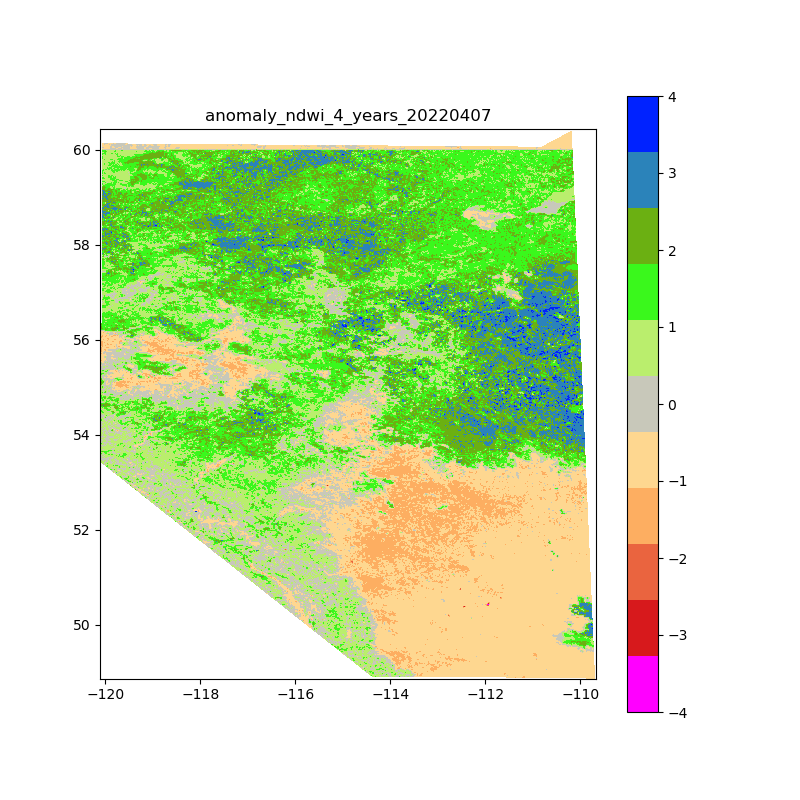

In [5]:
from IPython.display import Image
Image(filename='U:/RS_Task_Workspaces/bobo/NDWI/MOD09A1_2010-20/output/png/anomaly_ndwi_4_years_20220407.png')